<a href="https://colab.research.google.com/github/hanan99/CS-SBU-ComputationalNeuroScience2021-projects/blob/main/HananeHabibi-96222029/Assignment2/CN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.random import normal as np_normal, random as np_random
from numpy import arange, array
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from math import exp, sin

# **Neurons**

In [ ]:
"""#**LIF**"""

class LIF:
    def __init__(self, dt=0.03125, tau=8, theta=-45, R=10, U_rest=-79, U_reset=-65,
                 U_spike=5, ref_time=0, ref_period=0, weight_sens=1, is_exc=True, *args, **kwargs):
        self.dt = dt
        self.tau = tau
        self.theta = theta
        self.R = R / 1000
        self.U_rest = U_rest
        self.U_reset = U_reset
        self.U_spike = U_spike
        self.ref_period = ref_period
        self.U = self.U_rest
        self.is_exc = 1 if is_exc else -1

        self.last_fired = False
        self.ref_time = ref_time
        self.delay = 0
        self.weight_sens = weight_sens
        self.internal_clock = 0
        self.t_fired=[]
        self.post_syn = []
        self.pre_syn_input = 0
        self.pre_syn_input_delayed = []
        self.syn_input = 0
        self.pre_syn = []

    def du(self, It):
        self.U += (self.U_rest - self.U + self.R * It) * self.dt / self.tau

    def fire(self):
        self.t_fired.append(self.internal_clock)

        self.last_fired = True
        self.ref_time = self.ref_period
        self.U = self.U_spike

    def simulate_one_step(self, It):
        self.internal_clock += self.dt

        self.ref_time = max(self.ref_time - self.dt, 0)

        if self.last_fired or self.ref_time != 0:
            self.last_fired = False
            self.U = self.U_reset
            return self.U, It

        self.du(It)

        # if self.syn_input!=0 and self.post_syn==[]:
        #     print(self.internal_clock,self.syn_input, self.U)
        self.U += self.syn_input
        self.syn_input = 0

        if self.U >= self.theta: self.fire()
        # if len(self.t_fired)!=0 and self.internal_clock <= self.t_fired[-1]+1: self.send_pulse()
        if self.last_fired:
            self.send_pulse()

        return self.U, It

    def send_pulse(self):
        for post_neuron, _ in self.post_syn:
            post_neuron.pre_syn_input = self.is_exc * post_neuron.weight_sens if self.last_fired else 0


"""#**ELIF**"""

class ELIF(LIF):
    def __init__(self, theta_rh=-58, delta_t=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.theta_rh = theta_rh
        self.delta_t = delta_t

    def du(self, It):
        F = self.U_rest - self.U + self.delta_t * exp((self.U - self.theta_rh) / self.delta_t)
        self.U += (F + self.R * It) * self.dt / self.tau


"""#**AELIF**"""

class AELIF(ELIF):
    def __init__(self, a=0.01, b=500, tau_k=100, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.a = a
        self.b = b
        self.tau_k = tau_k
        self.w_k = 0

    def du(self, It):
        old_u = self.U

        self.U += (-(self.U - self.U_rest) + self.delta_t * (exp((self.U - self.theta_rh) / self.delta_t)) + self.R * It - (self.R * self.w_k)) * self.dt / self.tau

        if self.last_fired:
            self.w_k += (self.a * (old_u - self.U_rest) - self.w_k + self.tau_k * self.b) * self.dt / self.tau_k
        else:
            self.w_k += (self.a * (old_u - self.U_rest) - self.w_k) * self.dt / self.tau_k

    def simulate_one_step(self, I_t):
        u, _ = super().simulate_one_step(I_t)
        return u, self.w_k


In [ ]:
def plot_mv_ms(mv, time_list, name="", top=None, bottom=None, save=False, max_x=0):
    plt.plot(time_list, mv)
    plt.xlim(max_x, len(time_list)*0.03125)
    plt.ylim(top=top, bottom=bottom)
    plt.ylabel('Membrane Potential (mV)')
    plt.xlabel('Time (ms)')
    if name!="": name=" for "+name
    name="Voltage-Current"+name
    plt.title(name)
    if save: plt.savefig(name)
    plt.show()


def plot_current(current, time_list, name="", save=False, max_x=0):
    from matplotlib.pyplot import figure
    figure(figsize=(10, 5), dpi=80)
    plt.plot(time_list, current)
    plt.xlim(max_x, len(time_list)*0.03125)
    plt.ylabel('Input current (pA)')
    plt.xlabel('Time (ms)')
    if name!="": name=" for "+name
    name="Time-Current"+name
    plt.title(name)
    plt.xlim(max_x)
    if save: plt.savefig(name)
    plt.show()


def plot_internal_current(current, time_list, name=1,top=None, bottom=None):
    plt.plot(time_list, current)
    plt.ylabel('Adaption current (pA)')
    plt.xlabel('Time (ms)')
    plt.ylim(top=top, bottom=bottom)
    if name!=1: name=" for "+name
    name="Time-Adaption Current"+str(name)
    plt.title(name)
    # plt.savefig(name)
    plt.show()


def plot_raster(spike_history, idx_neuron, neuron_type, activity, runtime, dt, min_t=0):
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(2, 1)
    raster = fig.add_subplot(gs[0, 0])
    raster.set_title("Raster plot")
    raster.set(ylabel="Neuron", xlabel="time(S)")
    sns.scatterplot(ax=raster, y=idx_neuron, x=spike_history, hue=neuron_type, marker='.')
    raster.set(xlim=(min_t, runtime))

    pop_activity = fig.add_subplot(gs[1, 0])
    pop_activity.set_title("Population activity")
    pop_activity.set(ylabel="A(t)", xlabel="time(S)")
    sns.lineplot(ax=pop_activity, x=np.arange(0, runtime, dt), y=activity)
    pop_activity.set(ylim=(0, 0.015))
    pop_activity.set(xlim=(min_t, runtime))

    fig.show()


In [ ]:
class FullyConnectedPopulation:
    def __init__(self, J=0.5, stdp_eng=None, *args, **kwargs):
        self.J=J
        self.neurons = []
        self.conection_count=0
        self.stdp_eng=stdp_eng

        delay_range=(1,5); self.delay_seg=4
        self.delay_period=(delay_range[1]-delay_range[0])/self.delay_seg
        self.delay_timer=0

        self.populate_neurons(*args, **kwargs)
        self.create_network()

    def populate_neurons(self, n_type=None, n_config=None, excitatory=None, inhibitory=None, *args, **kwargs):
        for i in range(excitatory):
            self.neurons.append(eval('n_type(is_exc=True, ' + n_config + ')'))
        for i in range(inhibitory):
            self.neurons.append(eval('n_type(is_exc=False, ' + n_config + ')'))

    def create_network(self):
        for pre_neuron in self.neurons:
            for post_neuron in self.neurons:
                self.connect_neurons(pre_neuron, post_neuron)

    def connect_neurons(self, pre_neuron, post_neuron):
        if self.decide_to_connect() and post_neuron != pre_neuron:
            self.conection_count += 1
            pre_neuron.post_syn.append([post_neuron, [self.decide_weight() for i in range(self.delay_seg)]])
            post_neuron.pre_syn.append([len(pre_neuron.post_syn) - 1, pre_neuron])
            post_neuron.pre_syn_input_delayed = [0 for i in range(self.delay_seg)]

    def decide_to_connect(self):
        return True

    def decide_weight(self):
        return self.J / self.conection_count + np_normal(0.0, 0.001)

    # def draw_graph(self):
    #     import networkx as nx
    #     import pygraphviz
    #     import matplotlib.pyplot as plt
    #     ed=[]
    #     for pre_n_i, pre_neuron in enumerate(self.neurons):
    #         for post_neuron, w in pre_neuron.post_syn:
    #             ed.append([pre_n_i, self.neurons.index(post_neuron), w*1000//1/1000])
    #     G = nx.DiGraph()
    #     G.add_weighted_edges_from(ed)
    #     pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot', args="-Grankdir=LR")
    #     nx.draw(G,with_labels=True,pos=pos, font_weight='bold')

    #     edgewidth = [d['weight']*10 for (_, _, d) in G.edges(data=True)]
    #     # nx.draw_networkx_edges(G, pos, width=edgewidth)
    #     nx.draw_networkx_edges(G, pos, edge_color=edgewidth)

    #     plt.show()

    def fix_neurons(self, input_spike_list, output_spike_list):
        for neuron, to_spike in zip(
                self.input_neurons+self.output_neurons, input_spike_list+output_spike_list):
            neuron.syn_input=0;neuron.pre_syn_input=0
            if to_spike: neuron.U=neuron.U_spike+10
            elif neuron.U>neuron.U_reset: neuron.U=neuron.U_reset

    def simulate_network_one_step(self, I_t):
        u_history=[]
        i_history=[]
        for neuron in self.neurons:
            inter_U, curr = neuron.simulate_one_step(I_t)
            u_history.append(inter_U)
            i_history.append(curr)

        if self.delay_timer<=0:
            self.delay_timer=self.delay_period
            for neuron in self.neurons:
                neuron.syn_input += neuron.pre_syn_input_delayed[0]
                for _, post_w in neuron.post_syn:
                    neuron.pre_syn_input_delayed = [psi + w*neuron.pre_syn_input
                         for w, psi in zip(post_w,neuron.pre_syn_input_delayed[1:]+[0])]
                neuron.pre_syn_input = 0
        else: self.delay_timer -= neuron.dt

        for neuron in self.neurons:
            if self.stdp_eng!=None and neuron.last_fired: self.stdp_eng.train(neuron)

        # if neuron.internal_clock%20==0: print(neuron.internal_clock)

        return u_history, i_history


class FixedCouplingPopulation(FullyConnectedPopulation):
    def __init__(self, prob, *args, **kwargs):
        self.prob = prob
        super().__init__(*args, **kwargs)

    def decide_to_connect(self):
        return np_random() < self.prob

    def decide_weight(self):
        return self.J/self.conection_count/self.prob + np_normal(0.0, 0.01)


class GaussianFullyConnected(FullyConnectedPopulation):
    def __init__(self, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sigma = sigma

    def decide_weight(self):
        return np_normal(self.J/self.conection_count, self.sigma/self.conection_count)


class FullyConnectedPops(FullyConnectedPopulation):
    def populate_neurons(self, pre_pop=None, post_pop=None, *args, **kwargs):
        self.pre_pop = pre_pop
        self.post_pop = post_pop
        self.neurons = pre_pop.neurons+post_pop.neurons

    def create_network(self):
        for pre_neuron in self.pre_pop.neurons:
            for post_neuron in self.post_pop.neurons:
                self.connect_neurons(pre_neuron, post_neuron)


class FullyConnectedPops(FullyConnectedPopulation):
    def populate_neurons(self, pre_pop=None, post_pop=None, *args, **kwargs):
        self.pre_pop = pre_pop
        self.post_pop = post_pop
        self.neurons = pre_pop.neurons+post_pop.neurons

    def create_network(self):
        for pre_neuron in self.pre_pop.neurons:
            for post_neuron in self.post_pop.neurons:
                self.connect_neurons(pre_neuron, post_neuron)


class GaussianFullyConnectedPops(FullyConnectedPops):
    def __init__(self, sigma, *args, **kwargs):
        self.sigma = sigma
        super().__init__(*args, **kwargs)

    def decide_weight(self):
        return np_normal(self.J/self.conection_count, self.sigma/self.conection_count)


In [ ]:
def generate_spike_data(pop, runtime, dt, conv_size = 10):
    spike_history = []
    idx_neuron = []
    neuron_type=[]
    for idx, neuron in enumerate(pop.neurons):
        idx_neuron += [idx for i in neuron.t_fired]

        type=('exc' if neuron.is_exc == 1 else 'inh')
        try:
            if neuron in pop.output_neurons: type="output"
            elif neuron in pop.input_neurons: type="input"
        except: pass
        neuron_type += [type for i in neuron.t_fired]

        spike_history+=neuron.t_fired

    activity = np.bincount(np.array(np.array(spike_history)//dt, dtype = int))
    activity = np.pad(activity, (0, int(runtime//dt-len(activity)+1)), 'constant')[:int(runtime//dt)]
    conv=int(conv_size * (.1 / dt))
    activity = np.convolve(activity, conv*[1/conv], "same")/len(pop.neurons)

    return spike_history, idx_neuron, neuron_type, activity


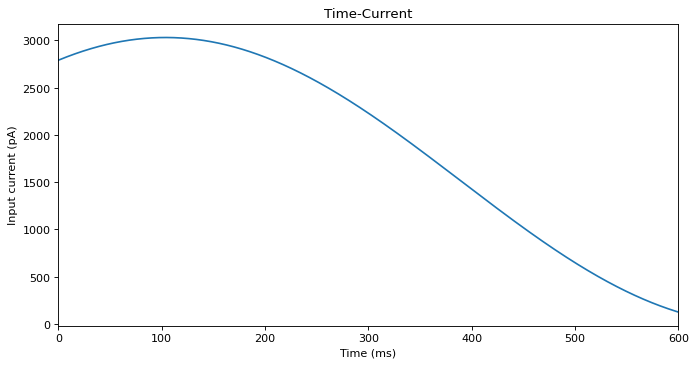

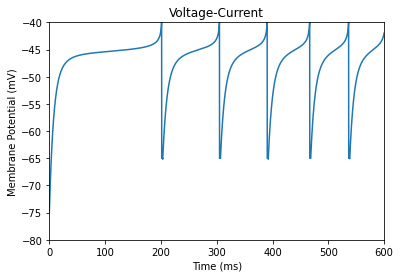

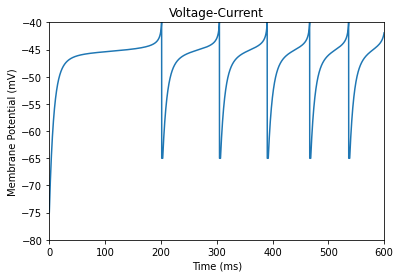

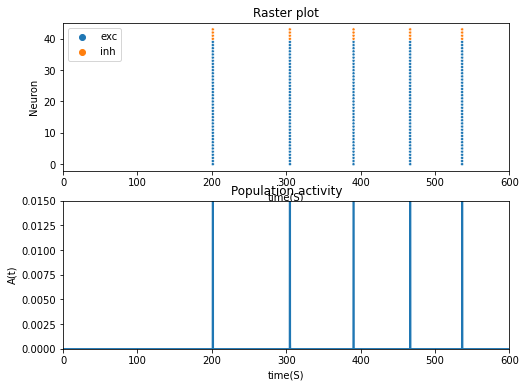

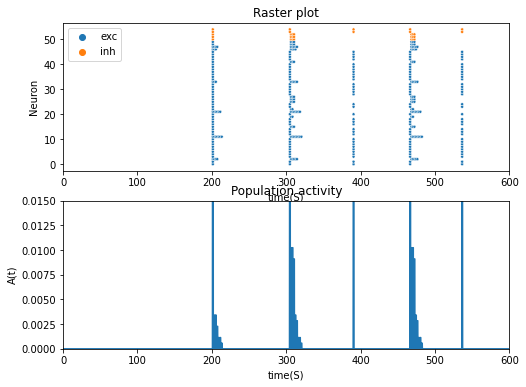

In [ ]:
dt=0.03125
model = GaussianFullyConnectedPops(
    J=6, sigma=1,
    post_pop=FixedCouplingPopulation(
        n_type=AELIF, excitatory=50, inhibitory=5, J=6.5, prob=0.01,
        n_config="dt="+str(dt)+", R=10, tau=8, theta=-40, U_rest=-75, U_reset=-65, U_spike=5, "
                  "weight_sens=1, ref_period=2, ref_time=0, theta_rh=-45, delta_t=2, a=0.01, b=500, tau_k=100"),
    pre_pop=FullyConnectedPopulation(
        n_type=AELIF, excitatory=40, inhibitory=4, J=2.5,
        n_config="dt="+str(dt)+", R=10, tau=8, theta=-40, U_rest=-75, U_reset=-65, U_spike=5, "
                  "weight_sens=1, ref_period=2, ref_time=0, theta_rh=-45, delta_t=2, a=0.01, b=500, tau_k=100")
    )

# model.draw_graph()
runtime=600; time_steps=int(runtime//dt)
curr_func = lambda x: 1515*(sin(x/time_steps*3.3+1)+1) # limited_sin(time_steps)
u_history=[]; i_history=[]
plot_current([curr_func(t) for t in range(time_steps)], arange(0,runtime, dt))
for t in range(time_steps):
    u, cur = model.simulate_network_one_step(curr_func(t*dt))
    u_history.append(u)
    i_history.append(cur)

# *******************************

plot_mv_ms(array(u_history)[:,1], arange(0,runtime, dt), top=-40, bottom=-80)
plot_mv_ms(array(u_history)[:,-1], arange(0,runtime, dt), top=-40, bottom=-80)

plot_raster(*generate_spike_data(model.pre_pop, runtime, dt), runtime, dt, min_t=0)
plot_raster(*generate_spike_data(model.post_pop, runtime, dt), runtime, dt, min_t=0)
